In [1]:
import tensorflow as tf
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras import Model
from tensorflow.keras.experimental import LinearModel

In [2]:
%config Completer.use_jedi = False

In [24]:
# Uncomment the following to disable GPU
tf.config.set_visible_devices([], 'GPU')
print(tf.config.get_visible_devices())
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
1 Physical GPUs, 0 Logical GPUs


# Import parquet data

In [4]:
ds = pq.ParquetDataset("/var/log/fancontrol/featurelog")
ptable = ds.read().to_pandas()

In [5]:
def clamp(num, min_value, max_value):
   return max(min(num, max_value), min_value)
power = ptable['power'].apply(lambda a: clamp(a[0], 0.0, 99.0))

In [208]:
def feature_names():
    fn = list(ptable.columns.values)
    fn = ['temp', 'power', 'label']
    fn.remove('label')
    return fn

def generator_types():
    return ({k: tf.float32 for k in feature_names()}, tf.float32)
print(generator_types())

def generator_shapes():
    for index, row in ptable.iterrows():
        shapes = {}
        for k in feature_names():
            if k == 'power':
                shapes[k] = (1,1)
            elif isinstance(row[k], float) or isinstance(row[k], int):
                shapes[k] = tuple()
            else:
                shapes[k] = (1, len(row[k]))
        return tuple([shapes, (1,)])
print(generator_shapes())

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

def convert(key, value):
    if key == 'temp':
        return tf.convert_to_tensor(value, tf.float32, name=key).reshape(1, 10)
    else:
        return tf.convert_to_tensor(value, tf.float32, name=key).reshape(1, 1)

def generator():
    for index, row in ptable.iterrows():
        f = {k: convert(k, row[k]) for k in feature_names()}
        l = tf.convert_to_tensor(list([float(row['label'])]), tf.float32, name='label')
        yield f, l

({'temp': tf.float32, 'power': tf.float32}, tf.float32)
({'temp': (1, 10), 'power': (1, 1)}, (1,))


In [209]:
all = tf.data.Dataset.from_generator(generator, output_types=generator_types(), output_shapes=generator_shapes()) \
    .shuffle(10, reshuffle_each_iteration=False)
n = next(all.batch(2).as_numpy_iterator())

In [210]:
tf.shape(n[0]['temp']).numpy()

array([ 2,  1, 10], dtype=int32)

In [179]:
for k in n[0]:
    print(k + ' -> ' + str(n[0][k]))

temp -> [[[47.   42.   41.   47.   41.   48.   40.   43.85 43.85 47.  ]]

 [[47.   42.   41.   47.   41.   48.   40.   43.85 43.85 47.  ]]]


In [180]:
tf.shape(n[1]).numpy()

array([2, 1], dtype=int32)

In [14]:
#for k in n[0]:
#    print(str(k) + " -> " + str(tf.shape(n[0][k])))

In [120]:
def is_test(x, y):
    return x % 4 == 0
def is_train(x, y):
    return not is_test(x, y)
recover = lambda x,y: y
test_dataset = all.enumerate() \
                    .filter(is_test) \
                    .map(recover)

train_dataset = all.enumerate() \
                    .filter(is_train) \
                    .map(recover)

# Lets build a simple model

In [121]:
from tensorflow.keras import layers
from tensorflow import keras

In [211]:
temp_input = Input(shape=(10,), name="temp")
power_input = Input(shape=(1,), name="power")
all_input = [power_input, temp_input]

In [212]:
x = layers.concatenate(all_input)

In [213]:
fanlevel_output = Dense(1, name="level")(x)

In [ ]:
linear_model=keras.Model(inputs=all_input, outputs=[fanlevel_output])
linear_model.compile(optimizer='adam', loss='msle')

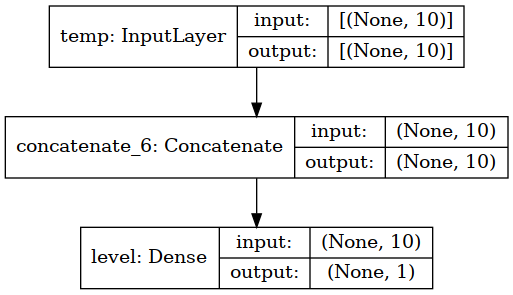

In [193]:
keras.utils.plot_model(linear_model, "multi_input_and_output_model.png", show_shapes=True)

In [194]:
linear_model.fit(train_dataset, epochs=1, batch_size=1024)

   4033/Unknown - 4s 750us/step - loss: 0.4860

KeyboardInterrupt: 

In [27]:
linear_model.save("first_train")

INFO:tensorflow:Assets written to: first_train/assets
